In [1]:
#default_exp evaluation

In [33]:
#export

import os
import pickle
import attr
from typing import List

import pandas as pd
import scipy
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

from game_recommender import steam_data, content_based, user_based, hybrid
from mlutil.evolutionary_algorithms import multiobjective

from pymoo.algorithms import moead, unsga3
from pymoo.factory import get_reference_directions
from pymoo import optimize

from pymoo.model.problem import get_problem_from_func

np.random.seed(0)

In [3]:
%cd ..

/home/kuba/Projects/game_recommender


In [4]:
game_dataset = steam_data.get_steam_ratings_dataset()

In [5]:
user_based_recommender = user_based.UserBasedRecommender.make_from_steam_data('log_hours')
content_based_recommender = content_based.ContentBasedRecommender.make_from_steam_metadata()

In [6]:
def display_2d_jointplot(arr, labels=[0, 1]):
    df = pd.DataFrame(arr, columns=labels)
    sns.jointplot(*labels, df)

# Recommendation evaluation metrics

We will use two ranking metrics to evaluate the recommender.


## recall@k
It is  essentially false negative rate for top $k$ items. For a sequence $I$ of ratings and $\hat{I}$ of predicted items 

$recall@k(I, \hat{I}) = \frac{1}{min(k, |I|)}|I \cap \hat{I}| $

## Kendall's $\tau$
The second metric is used to measure how similar are orderings of $I$ and $\hat{I}$.

For a pair of zipped of items from $I, I'$

$((i_k, i'_k)$ $(i_j, i'_j))$ is said to be *concordant* if their signs are not zero and coincide: $sign(i_k -  i_j) = sign(i'_k - i'_j)$. It is said to be *disconcordant* if the signs are not equal.

Kendall rank correlation coefficient for two rankings with $n_c$ concordant pairs and $n_d$ disconcordant pairs is defined as

$\tau = \frac{n_c - n_d}{n \choose k}$


## Tradeoffs

Since recall measures false negative rate, increasing number of recommended items will never decrease it. On the other hand adding recommendations changes ranking, so by adding noisy entries it might decrease $\tau$



In [7]:
#export


class metrics:
        
    @staticmethod
    def get_correlation(user_ratings, recommendations, method=scipy.stats.kendalltau):
        user_ratings_with_zeros, recommendations_with_zeros, n_compared = metrics._make_data_for_correlation_comparison(user_ratings, recommendations) 
        return method(user_ratings_with_zeros[:n_compared], recommendations_with_zeros[:n_compared])[0]

    @staticmethod
    def get_recall_at(user_ratings, recommendations, k=10):
        user_games = user_ratings.sort_values(ascending=False)[:k]
        recommended_games = recommendations.sort_values(ascending=False)[:k]
        return recommended_games.index.isin(user_games.index).sum() / len(user_games)

    @staticmethod
    def _fill_nonexistent_with_zeros(source, target):
        not_in_source = target[~target.index.isin(source.index)].index
        zeroed_not_in_source = pd.Series(index=not_in_source, data=np.zeros_like(not_in_source))
        return pd.concat([source, zeroed_not_in_source])

    @staticmethod
    def _make_data_for_correlation_comparison(user_ratings, recommendations):
        user_ratings_with_zeros = metrics._fill_nonexistent_with_zeros(recommendations, user_ratings)
        recommendations_with_zeros = metrics._fill_nonexistent_with_zeros(user_ratings, recommendations)[user_ratings_with_zeros.index]
        n_compared = min([len(user_ratings), len(recommendations)])
        return user_ratings_with_zeros, recommendations_with_zeros, n_compared


In [8]:
user_item_df = game_dataset.get_user_item_df()

# Evaluating recommendations for an example user

In [9]:
i = 10
user_id = user_based_recommender.user_similarity_searcher.df.iloc[i,0]
user_ratings_raw = user_item_df.iloc[i]
user_ratings = user_ratings_raw[~user_ratings_raw.isna()]

In [10]:
user_ratings

name
counter strike                     3.135494
counter strike global offensive    6.194405
counter strike nexon zombies       0.693147
counter strike source              0.693147
day of defeat                      0.693147
deathmatch classic                 0.693147
eldevin                            0.693147
half life                          0.693147
half life blue shift               0.693147
half life opposing force           0.693147
planetside 2                       0.693147
raceroom racing experience         0.336472
realm of the mad god               0.693147
ricochet                           0.693147
team fortress classic              0.693147
unturned                           0.693147
warface                            0.693147
Name: 547685, dtype: float64

### Example recommendations

In [11]:
recommender = hybrid.HybridRecommender(content_based_recommender, user_based_recommender)
recommendations = recommender.get_weighted_recommendations(user_ratings, 20, user_recommendation_weight=1, content_recommendation_weight=1, mean_content_recommendation_weight=1)
recommendations

counter strike global offensive    2.800790
call of duty 4 modern warfare      2.518721
world of tanks blitz mmo           1.916409
counter strike                     1.832181
tanki online                       1.738157
blockade classic                   1.729970
team fortress 2                    0.986183
warface                            0.967958
post scriptum                      0.961721
planetside 2                       0.957287
call of duty black ops 2           0.956847
argo                               0.954355
squad                              0.952416
counter strike source              0.913655
counter strike nexon zombies       0.883508
tera                               0.804729
arma 2 operation arrowhead         0.795574
supreme commander 2                0.760804
insurgency                         0.746282
rise of liberty                    0.713363
dtype: float64

Recall

In [12]:
metrics.get_recall_at(user_ratings, recommendations)

0.3

Kendall $\tau$

In [13]:
metrics.get_correlation(user_ratings, recommendations, method=scipy.stats.kendalltau)

0.12871918058696763

# Hybrid recommender

Hybrid recommender combines three recommendation methods:

1. user-based similarity

2. content-based similarity

3. mean content based similarity


Using recommendations from different sources gives is beneficial because different methods may suffer from different problems.


### 1. User-based similarity

This method for given ratings calculates users that have similar taste: it compares users using cosine similarity of their ratings.

User-based collaborative filtering is 

Drawbacks:

- cold start problem - we do not know what to recommend to users that have very few ratings.
- the method will have very different quality depending on number of rated items. In our dataset we have less than 20 ratings for most of users, but some of them rated more than 100 games.


### 2. Content-based similarity

Calculates similarity, but for items instead of users. Then returns games that were similar to rated games - their ratings are interpolated from rated games weighted by cosine similarity.

For content features [steam metadata](https://www.kaggle.com/trolukovich/steam-games-complete-dataset) was used: for each game columns with tags and descriptions were vectorized using TF-IDF.

By definition will recommend items similar to the ones that were rated. This may result in too conservative recommendations - there is no serendipity.

### 3. Mean content-based similarity

This method computes mean of item feature vectors and then 

In [14]:
@attr.s
class HybridRecommenderEvaluator:
    
    recommender: hybrid.HybridRecommender = attr.ib()
        
    def get_per_user_recommendation_groups(self, users_ratings, n_recommended=20, n_similar_users=10, n_similar_items=10):
        return [recommender.get_recommendation_groups(user_ratings, n_similar_users, n_similar_items) for user_ratings in users_ratings]
    
    def get_metric_values(
            self,
            users_ratings,
            user_recommendations_groups,
            n_recommended,
            metric,
            user_recommendation_weight=1,
            content_recommendation_weight=1,
            mean_content_recommendation_weight=1
            ):
        
        weights = [user_recommendation_weight, content_recommendation_weight, mean_content_recommendation_weight]
        metric_values = [
            metric(users_ratings, recommender.weigh_recommendations(user_recommendation_group, weights, n_recommended))
            for users_ratings, user_recommendation_group in zip(user_ratings, user_recommendations_groups)
        ]
        return pd.Series(metric_values)

In [15]:
class HybridRecommenderOptimizer:
    
    def __init__(
            self,
            evaluator: HybridRecommenderEvaluator,
            users_ratings: List[pd.Series],
            n_recommended=10,
            n_similar_users=5,
            n_similar_items=5,
            k_recall=10):
        self.evaluator = evaluator
        self.users_ratings = users_ratings
        self.n_recommended = n_recommended
        self.recommendation_groups = evaluator.get_per_user_recommendation_groups(user_ratings, n_recommended, n_similar_users, n_similar_items)
        self.k_recall = k_recall
    
    def problem_function(self, weights):
        if len(weights) == 2:
            [user_recommendation_weight, content_recommendation_weight] = weights
            mean_content_recommendation_weight = max(0, 1 - user_recommendation_weight - content_recommendation_weight)
        else:
            [user_recommendation_weight, content_recommendation_weight, mean_content_recommendation_weight] = weights / weights.sum() 
        recall = self.evaluator.get_metric_values(
            self.users_ratings,
            self.recommendation_groups,
            self.n_recommended,
            partial(metrics.get_recall_at, k=self.k_recall),
            user_recommendation_weight,
            content_recommendation_weight,
            mean_content_recommendation_weight
        )

        rank_correlation = self.evaluator.get_metric_values(
            self.users_ratings,
            self.recommendation_groups,
            self.n_recommended,
            metrics.get_correlation,
            user_recommendation_weight,
            content_recommendation_weight,
            mean_content_recommendation_weight
        )
        return np.array([recall.mean(), rank_correlation.mean()])
    
    def problem_function_vectorized(self, weights):
        recalls = []
        rank_correlations = []
        for i in range(len(weights)):
            recall, rank_correlation = self.problem_function(weights[i])
            recalls.append(recall.mean())
            rank_correlations.append(rank_correlation.mean())
        return np.column_stack([recalls, rank_correlations])


# Evaluating Hybrid Recommender

Since our recommenders use kNN models, it makes sense to evaluate recommendations for separate users separately: this is basically Leave One Out scheme for crossvalidation.

In [16]:
user_item_df_with_rankings = user_item_df[user_item_df.var(axis=1) > 1e-4]

In [17]:
n_test = 200 
users_ratings_raw = user_item_df_with_rankings.iloc[:n_test]
user_ratings = [ratings.dropna() for (__, ratings) in users_ratings_raw.iterrows()]
rating_counts = [len(ratings) for ratings in user_ratings]

In [18]:
evaluator = HybridRecommenderEvaluator(recommender)

In [19]:
%%time
optimizer = HybridRecommenderOptimizer(evaluator, user_ratings)

CPU times: user 1min 23s, sys: 3.02 s, total: 1min 26s
Wall time: 1min 26s


In [20]:
rec_groups = optimizer.recommendation_groups

## Baseline results 

Baseline results are retrieved using equal weights for different recommendation methods.

## recall@10

mean recall: 0.616


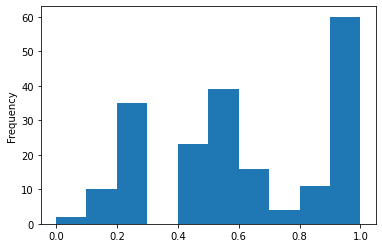

In [21]:
recall = evaluator.get_metric_values(rec_groups, rec_groups, 10, metrics.get_recall_at, 1, 1, 1)
recall.plot.hist()
print('mean recall: {:.3f}'.format(recall.mean()))

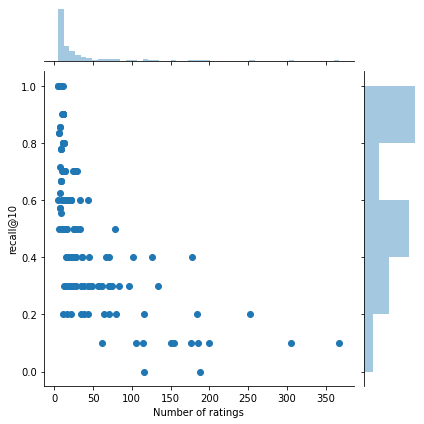

In [22]:
display_2d_jointplot(np.column_stack([rating_counts, recall]), ('Number of ratings', 'recall@10'))

## Kendall $\tau$

mean tau: 0.119


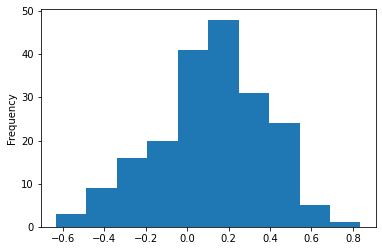

In [23]:
tau = evaluator.get_metric_values(rec_groups, rec_groups, 10, partial(metrics.get_correlation, method=scipy.stats.kendalltau), 1, 1, 1)
tau.plot.hist()
print('mean tau: {:.3f}'.format(tau.mean()))

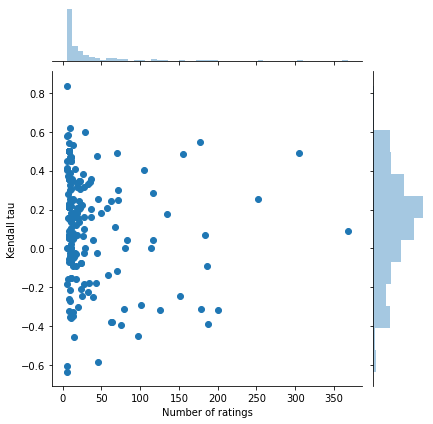

In [24]:
display_2d_jointplot(np.column_stack([rating_counts, tau]), ('Number of ratings', 'Kendall tau'))

## Multiobjective optimization

Since we're interested in optimizing with respect to two metrics, we need to use multiobjective optimization methods.

One evolutionary method that can be used with multiple criterions is [NSGA-II algorithm](https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf).

In the following we try to find Pareto frontier for jointly optimizing recall and Kendall $\tau$.

In [25]:

nsga_alg = multiobjective.NSGAII(
    optimizer.problem_function,
    chromosome_size=3,
    mutation_function=partial(multiobjective.bounded_gaussian_noise_mutation, sigma=0.01),
    objective_names=('recall@10', 'Kendall tau'),
    minimize=False
)

  0%|          | 0/10 [00:00<?, ?it/s]

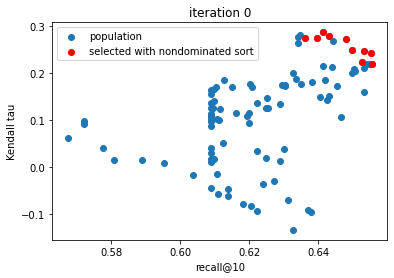

 10%|█         | 1/10 [02:11<19:47, 131.93s/it]

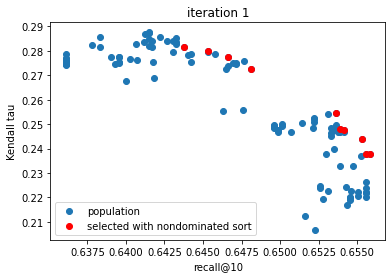

 20%|██        | 2/10 [04:29<17:48, 133.55s/it]

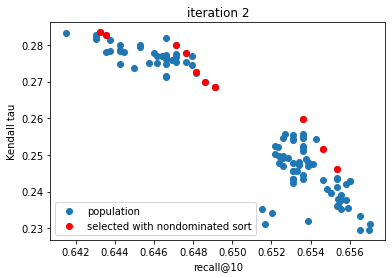

 30%|███       | 3/10 [06:44<15:37, 133.98s/it]

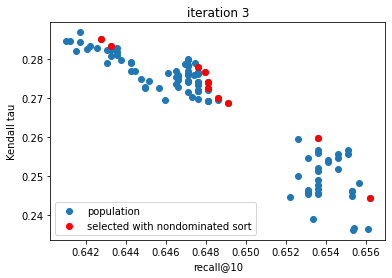

 40%|████      | 4/10 [09:01<13:29, 134.87s/it]

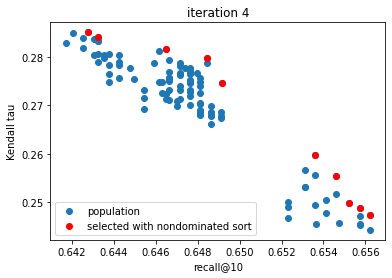

 50%|█████     | 5/10 [11:20<11:20, 136.19s/it]

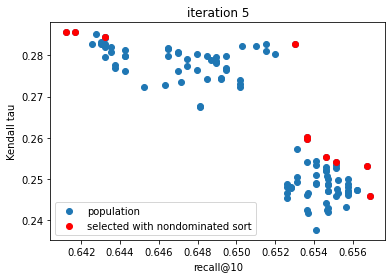

 60%|██████    | 6/10 [13:46<09:16, 139.02s/it]

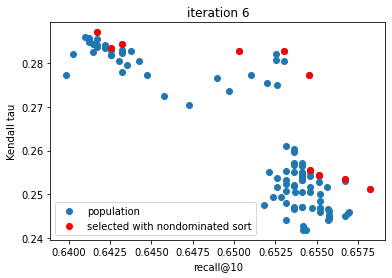

 70%|███████   | 7/10 [16:05<06:57, 139.01s/it]

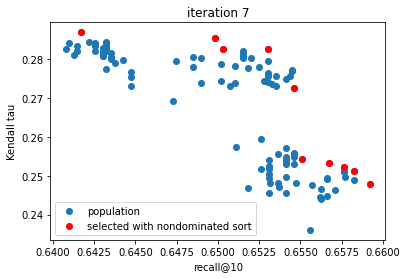

 80%|████████  | 8/10 [18:27<04:40, 140.07s/it]

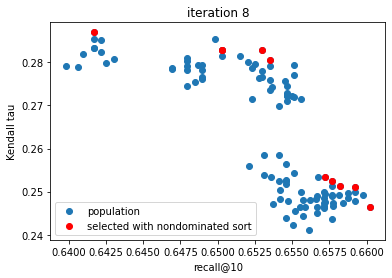

 90%|█████████ | 9/10 [20:54<02:21, 141.98s/it]

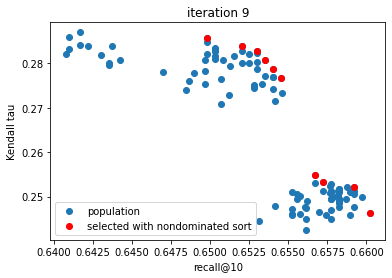

100%|██████████| 10/10 [23:22<00:00, 140.25s/it]

CPU times: user 23min 24s, sys: 1.33 s, total: 23min 25s
Wall time: 23min 22s


In [26]:
%%time
recommender_weights_simple = nsga_alg.optimize(population_size=100, n_selected=10, n_iterations=10, log_period=1)

# NSGA with bigger population size

  0%|          | 0/10 [00:00<?, ?it/s]

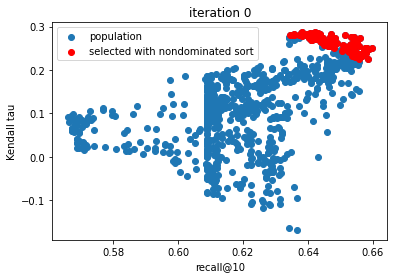

 10%|█         | 1/10 [21:18<3:11:47, 1278.61s/it]

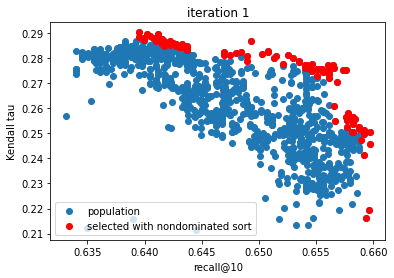

 20%|██        | 2/10 [43:43<2:53:08, 1298.56s/it]

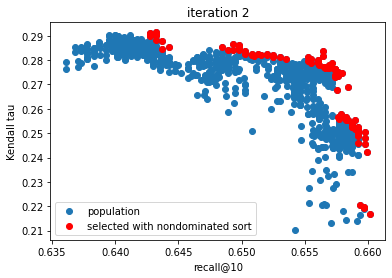

 30%|███       | 3/10 [1:06:05<2:33:00, 1311.46s/it]

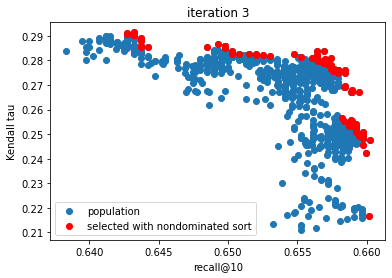

 40%|████      | 4/10 [1:28:17<2:11:45, 1317.58s/it]

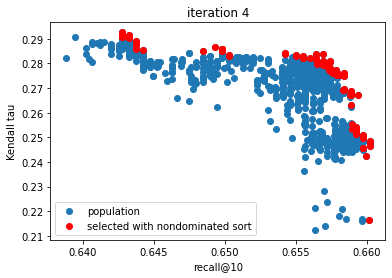

 50%|█████     | 5/10 [1:50:17<1:49:52, 1318.54s/it]

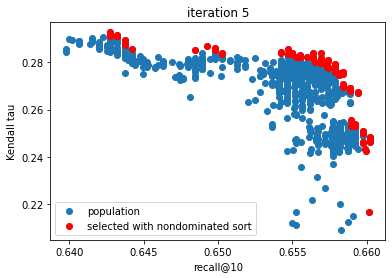

 60%|██████    | 6/10 [2:12:21<1:27:59, 1319.98s/it]

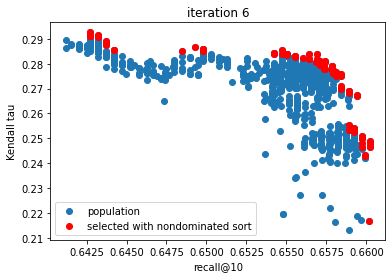

 70%|███████   | 7/10 [2:34:22<1:06:00, 1320.24s/it]

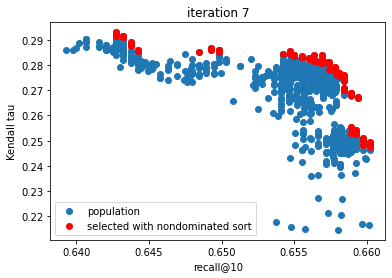

 80%|████████  | 8/10 [2:56:20<43:59, 1319.65s/it]  

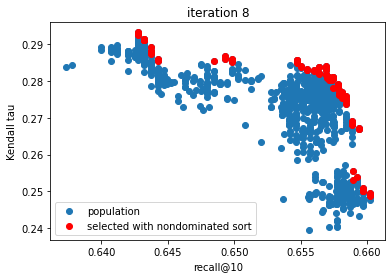

 90%|█████████ | 9/10 [3:18:27<22:02, 1322.03s/it]

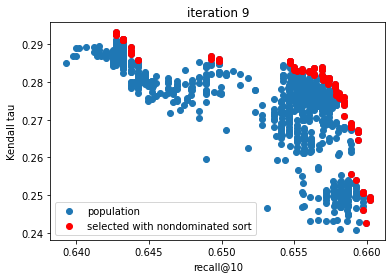

100%|██████████| 10/10 [3:40:24<00:00, 1322.43s/it]

CPU times: user 3h 40min 12s, sys: 18.3 s, total: 3h 40min 30s
Wall time: 3h 40min 24s


In [27]:
%%time
recommender_weights = nsga_alg.optimize(population_size=1000, n_selected=100, n_iterations=10, log_period=1)

# Visualizing weights

Because the input is 3d vector for which scale is irrelevant (multiplying rating weights doesn't change ordering) the weights can be visualized as points from 2d simplex.

The following plot visualizes selected weights as a subset of a triangle. 

In [28]:
def display_2d_jointplot(arr):
    df = pd.DataFrame(arr)
    sns.jointplot(0, 1, df)

    
def display_weights_simplex(recommender_weights):
    norm_weights = recommender_weights / recommender_weights.sum(axis=1)[:,np.newaxis]
    fig, ax = plt.subplots()
    ax.scatter(norm_weights[:,0], norm_weights[:,1], c='black');

    ax.plot([0, 1], [1, 0], c='red')
    ax.plot([0, 0], [1, 0], c='red')
    ax.plot([0, 1], [0, 0], c='red')
    ax.annotate('content', (0, 1))
    plt.annotate('mean content', (0, 0), ha='left', rotation=45)
    plt.annotate('user', (1, 0), rotation=90)
    plt.show()
    display_2d_jointplot(norm_weights)
    plt.show()

Since weights found by NSGA occupy only a small fraction of all possible weights, let's zoom in.

It seems like genetic algorithm indeed found several potential solutions.

In [29]:
nsga_pareto_front = recommender_weights[multiobjective._nsga_selection(100, recommender_weights)]
nsga_pareto_front = nsga_pareto_front / nsga_pareto_front.sum(axis=1)[:, np.newaxis]

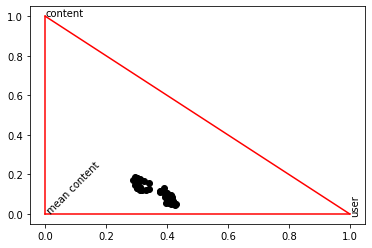

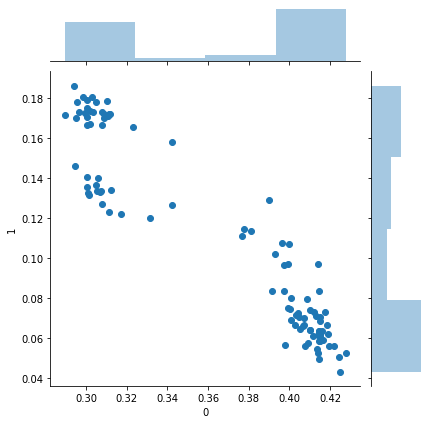

In [30]:
display_weights_simplex(nsga_pareto_front)

# Multiobjective optimization using PyMOO

## UNSGA-III

[An Evolutionary Many-Objective Optimization Algorithm Using Reference-point Based Non-dominated Sorting Approach](https://www.egr.msu.edu/~kdeb/papers/k2012009.pdf)

Algorithm that is an improved version of NSGA.

Key differences:

- using *reference directions* (NSGA-III)
- using tournament method for parent selection


Reference directions were introduced to sidestep the problem with multidimensional optimization: in high dimensions Pareto front size grows exponentially, and standard methods from NSGAII might become less meaningful, computationally more expensive and harder to visualize/evaluate.

To address this, a set of diverse points is chosen at start, and optimization for subpopulations proceeds to make it closer to these *reference points*.

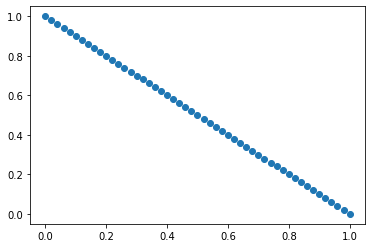

In [46]:
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=50)
plt.scatter(ref_dirs[:,0], ref_dirs[:,1]);

In [47]:
def pymoo_optimized_function_wrapper(x, out, *args, **kwargs):
    values = [optimizer.problem_function(x[i]) for i in range(len(x))]
    out['F'] = -np.array(values)
    

pymoo_problem = get_problem_from_func(pymoo_optimized_function_wrapper, xl=1e-6, xu=1, n_var=3)

In [48]:
unsga_alg = unsga3.UNSGA3(
    ref_dirs,
    pop_size=100
)

In [49]:
%%time
unsga_results = optimize.minimize(pymoo_problem, unsga_alg, termination=('n_gen', 25), verbose=True)

n_gen |  n_eval |  n_nds  | delta_ideal  | delta_nadir  |   delta_f   
    1 |     100 |       5 |            - |            - |            -
    2 |     200 |       7 |  0.00000E+00 |  0.00000E+00 |  0.083334451
    3 |     300 |       6 |  0.061221865 |  0.320962148 |  0.071146816
    4 |     400 |       6 |  0.044253227 |  0.378169240 |  0.088540935
    5 |     500 |       6 |  0.009319475 |  0.098415161 |  0.048327864
    6 |     600 |       7 |  0.003093581 |  0.146405827 |  0.147355155
    7 |     700 |       8 |  0.028828376 |  0.803630240 |  0.057507092
    8 |     800 |       5 |  0.026274632 |  0.160178944 |  0.074241338
    9 |     900 |       8 |  0.00000E+00 |  0.00000E+00 |  0.027971584
   10 |    1000 |      10 |  0.00000E+00 |  0.00000E+00 |  0.072798363
   11 |    1100 |       9 |  0.010411081 |  0.015588263 |  0.029481635
   12 |    1200 |      12 |  0.00000E+00 |  0.00000E+00 |  0.033463840
   13 |    1300 |      11 |  0.00000E+00 |  0.00000E+00 |  0.010030896
   14 

## UNSGA objectives

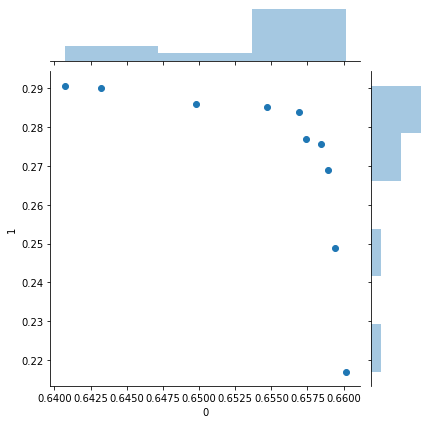

In [50]:
display_2d_jointplot(-unsga_results.F)

## UNSGA weights

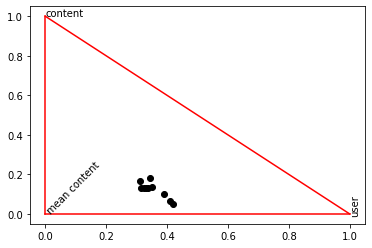

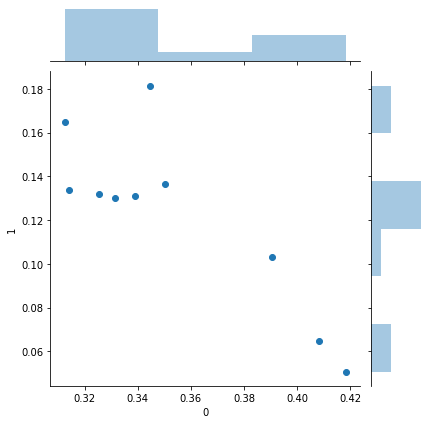

In [51]:
display_weights_simplex(unsga_results.X)

# MOEA/D

*MOEA/D: A Multiobjective Evolutionary Algorithm Based on Decomposition*

MOEA/D is a multiobjective optimization algorithm that uses **decomposition** into scalar subproblems.

The scalar subproblems are chosen so that optimizing them separately yields good approximation of Pareto Frontier, at least when subpopulations that optimize them are not too similar.

### Decomposition

MOEA/D redefines optimization problem as separate single ojective optimization problems: for given $\lambda$ it weights objectives of $f(x)$ .

An example of such approach is scalarization: $g(x) = \lambda^T f(x)$

Chosen weight vectors $\Lambda = (\lambda^i)_{i < k}$ represent tradeoffs between optimizing different objectives (with respect to a given reference point).

For each of these $\lambda$ we have a single objective function - this problem can be solved using classical Evolutionary Algorithms.

The usefulness of this approach is that $g$s are similar for similar $\lambda$s, so we can reuse knowledge obtained optimizing using close $\lambda$s. 

### Decomposition using Chebyshev approach

Original MOEAD uses so-called Chebyshev approach: for $m$ objectives, vector of subproblem weights $\lambda$ and a reference point $z \in R^m$ we define 

$g^{Ch}(x | \lambda, z) = \|\lambda_i^T (f(x) - z)\|_{\infty} = max_{i < m} \lambda_i |f_i(x) - z_i|$


In [56]:
moead_alg = moead.MOEAD(
    ref_dirs,
    n_neighbors=15,
    decomposition="tchebicheff",
    seed=1
)

In [57]:
%%time
moead_results = optimize.minimize(pymoo_problem, moead_alg, termination=('n_gen', 25), verbose=True)

n_gen |  n_eval |  n_nds  | delta_ideal  | delta_nadir  |   delta_f   
    1 |      51 |       4 |            - |            - |            -
    2 |     102 |      40 |  0.471541980 |  3.090198899 |  0.425700131
    3 |     153 |      49 |  0.204836113 |  0.033622415 |  0.182016928
    4 |     204 |      27 |  0.046801475 |  0.134664544 |  0.083199851
    5 |     255 |      45 |  0.005660764 |  0.00000E+00 |  0.014826860
    6 |     306 |      44 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    7 |     357 |      45 |  0.098683271 |  0.116020236 |  0.037005189
    8 |     408 |      36 |  0.00000E+00 |  0.00000E+00 |  0.002658564
    9 |     459 |      38 |  0.027550016 |  0.211552932 |  0.054550594
   10 |     510 |      45 |  0.00000E+00 |  0.00000E+00 |  0.000959984
   11 |     561 |      46 |  0.00000E+00 |  0.00000E+00 |  0.001685668
   12 |     612 |      46 |  0.00000E+00 |  0.00000E+00 |  0.000601338
   13 |     663 |      45 |  0.00000E+00 |  0.080043900 |  0.003805380
   14 

## MOEA/D results

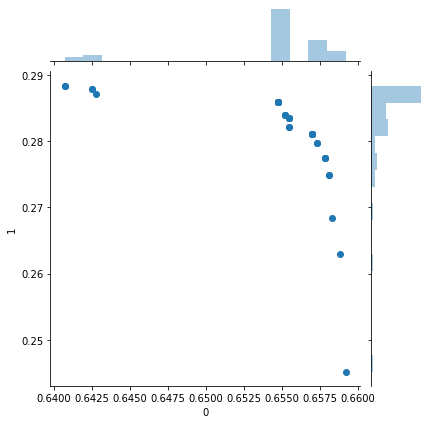

In [58]:
display_2d_jointplot(-moead_results.F)

## MOEA/D weights

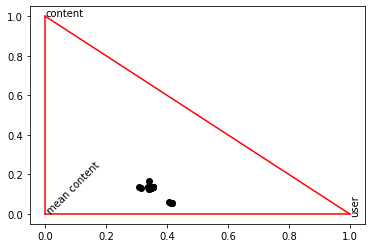

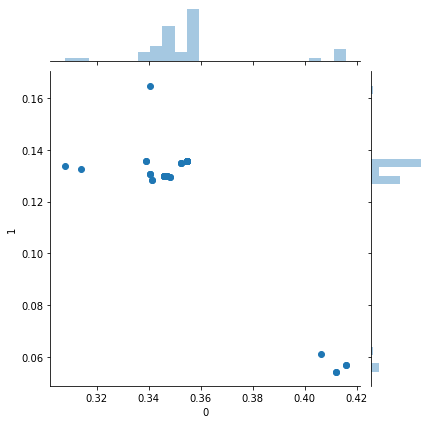

In [59]:
display_weights_simplex(moead_results.X)